In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
from sklearn.svm import SVC
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neural_network import MLPClassifier

In [3]:
spotify_dataset_train = pd.read_csv("datasets/dataset_part_1/spotify_dataset_train.csv")
spotify_dataset_test = pd.read_csv("datasets/dataset_part_1/spotify_dataset_test.csv")

In [4]:
print(f"Dimensions du jeu de données d'entrainement : {spotify_dataset_train.shape[0]} lignes et {spotify_dataset_train.shape[1]} caractéristiques.")

Dimensions du jeu de données d'entrainement : 25492 lignes et 17 caractéristiques.


In [5]:
spotify_dataset_train.head()

,release_date,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,2015-06-23,False,38,0.509,0.8720,2,-5.170,1,0.0547,0.0396,0.000015,0.3310,0.4860,95.969,194375,4,country
1,2021-11-12,False,58,0.182,0.0377,11,-33.748,0,0.0391,0.9870,0.957000,0.0804,0.0923,100.482,241804,4,classical
2,2013-06-21,False,36,0.550,0.9410,0,-3.128,0,0.0849,0.0182,0.003750,0.3120,0.3510,145.006,260276,4,rap
3,2012-09-04,False,0,0.569,0.7190,6,-8.399,0,0.0663,0.8670,0.941000,0.1760,0.6430,145.118,165200,4,blues
4,2008,False,0,0.631,0.6610,8,-5.694,1,0.0558,0.0146,0.720000,0.3650,0.3300,130.004,245933,4,dance


In [6]:
genre_counts = spotify_dataset_train["genre"].value_counts()
print(f"Nombre de genres :\n{genre_counts}")

Nombre de genres :
genre
pop          5181
rock         3695
hip hop      2926
rap          1654
edm          1593
jazz         1516
dance        1371
electro      1081
country      1042
punk          994
metal         578
soul          505
chanson       489
classical     393
latin         378
folk          372
disco         355
r&b           352
reggae        281
techno        265
blues         246
salsa         225
Name: count, dtype: int64


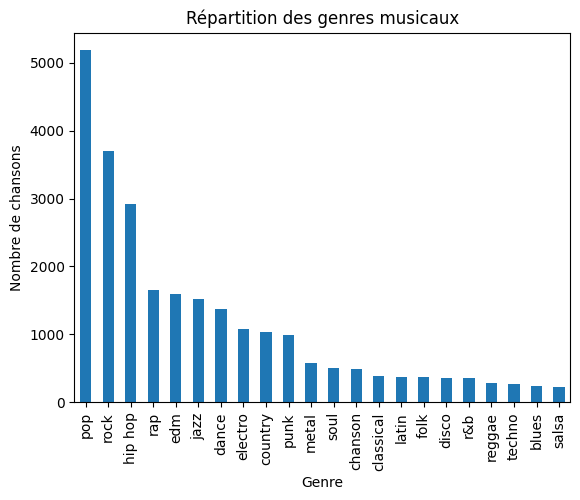

In [7]:
genre_counts.plot(kind="bar")
plt.title("Répartition des genres musicaux")
plt.xlabel("Genre")
plt.ylabel("Nombre de chansons")
plt.show()

# PART 1 - Song classification and recommendation

# **Exercice 1**

In [8]:
y = spotify_dataset_train["genre"]
X = spotify_dataset_train.drop("genre", axis=1)

X['year'] = pd.to_datetime(X['release_date'], format='mixed').dt.year
X = X.drop(columns=['release_date'])
X["explicit"] = X["explicit"].astype(int)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=17)

In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

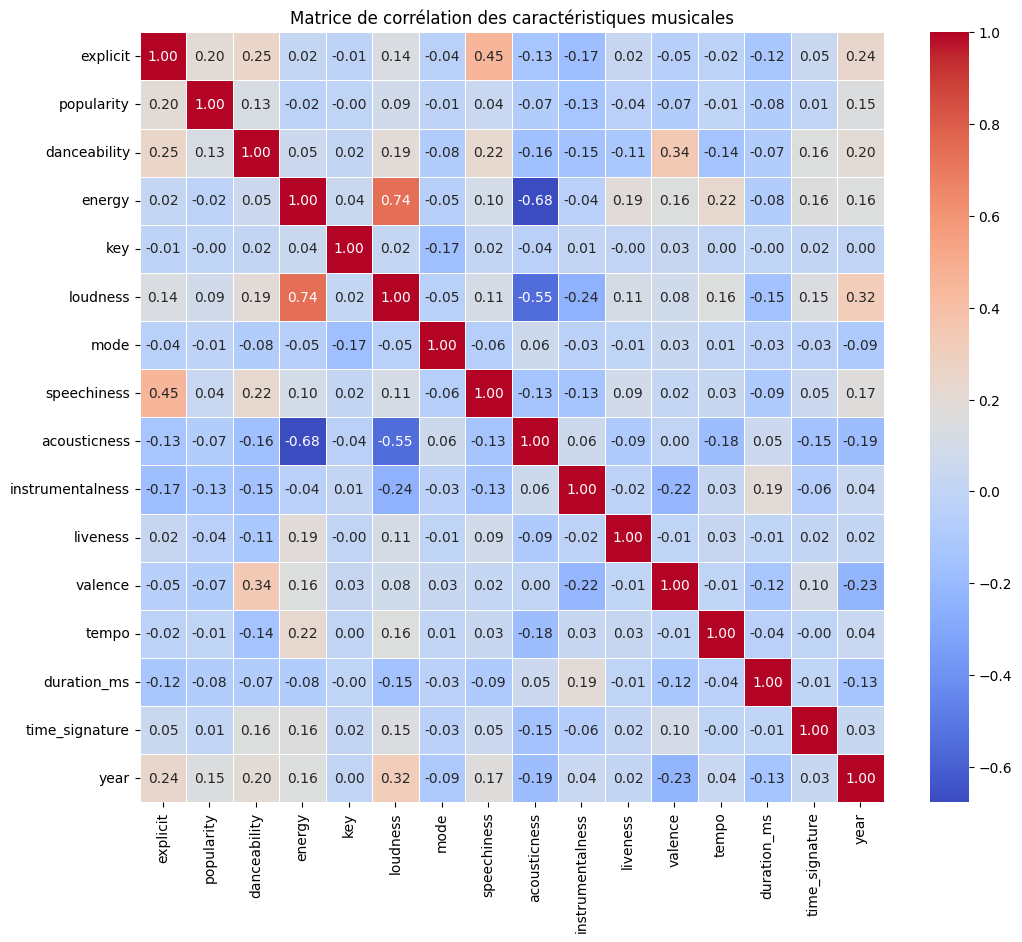

In [11]:
corr_matrix = X.select_dtypes(include=['number']).corr()

plt.figure(figsize=(12, 10))

sns.heatmap(corr_matrix, 
            annot=True,       
            fmt=".2f",         
            cmap='coolwarm',   
            linewidths=0.5)

plt.title("Matrice de corrélation des caractéristiques musicales")
plt.show()

In [12]:
f1_scores = {}

## Models

### Decision Tree

In [13]:
clf_tree = DecisionTreeClassifier(
    max_depth=15, 
    class_weight="balanced", 
    random_state=17)
    
clf_tree.fit(X_train, y_train)

y_pred = clf_tree.predict(X_test)

In [14]:
f1 = f1_score(y_test, y_pred, average="micro")
f1_scores["DecisionTree"] = f1
print(f"F1-Score : {f1:.4f}")

F1-Score : 0.2808


### Random Forest

In [15]:
random_forest = RandomForestClassifier(
    n_estimators=500,
    min_samples_leaf=2, 
    class_weight="balanced_subsample", 
    random_state=17, 
    n_jobs=-1)
    
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

In [16]:
f1 = f1_score(y_test, y_pred, average="micro")
f1_scores["RandomForest"] = f1
print(f"F1-Score : {f1:.4f}")

F1-Score : 0.4762


### XGBoost

In [17]:
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)

In [18]:
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [19]:
xgb_classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05, 
    max_depth=8, 
    subsample=0.8, 
    colsample_bytree=0.8,
    tree_method='hist'
    )
    
xgb_classifier.fit(X_train, y_train_encoded, sample_weight=weights)

y_pred = xgb_classifier.predict(X_test)

In [20]:
f1 = f1_score(y_test_encoded, y_pred, average="micro")
f1_scores["XGBoost"] = f1
print(f"F1-Score : {f1:.4f}")

F1-Score : 0.4713


### SVM Classifier

In [21]:
svm = SVC(
    kernel="rbf",
    class_weight="balanced",
    random_state=17
    )
    
svm.fit(X_train_scaled, y_train)

y_pred = svm.predict(X_test_scaled)

In [22]:
f1 = f1_score(y_test, y_pred, average='micro')
f1_scores["SVM"] = f1
print(f"F1-score : {f1:.4f}")

F1-score : 0.3387


### MLP Classifier

In [23]:
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=64,
    learning_rate_init=0.001,
    max_iter=200,
    random_state=42,
    early_stopping=True
)
mlp.fit(X_train_scaled, y_train_encoded)

y_pred = mlp.predict(X_test_scaled)

In [24]:
f1 = f1_score(y_test_encoded, y_pred, average='micro')
f1_scores["MLP"] = f1
print(f"F1-score : {f1:.4f}")

F1-score : 0.4528


## **Result Analysis**

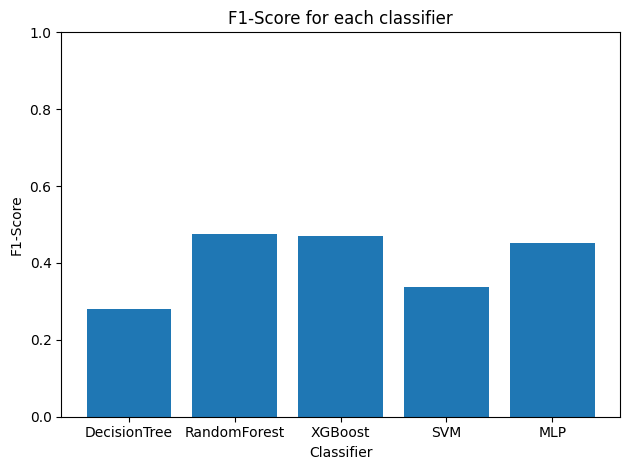

In [25]:
plt.bar(f1_scores.keys(), f1_scores.values())
plt.ylim(0, 1)
plt.xlabel("Classifier")
plt.ylabel("F1-Score")
plt.title("F1-Score for each classifier")
plt.tight_layout()

## Dataset Prediction

In [26]:
spotify_dataset_test.head()

,release_date,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2018-03-16,True,83,0.699,0.304,1,-11.192,1,0.0993,0.77900,0.000993,0.1370,0.271,119.705,160184,4
1,2003,False,44,0.590,0.722,4,-5.783,1,0.0265,0.00052,0.000009,0.0712,0.670,116.035,166645,4
2,2012-01-01,False,0,0.362,0.435,2,-7.241,1,0.0280,0.27400,0.000001,0.1580,0.349,141.970,220693,4
3,2001-10-23,False,57,0.571,0.617,2,-5.032,1,0.0348,0.32800,0.000000,0.1150,0.574,88.154,187373,4
4,2020-09-18,False,56,0.578,0.748,0,-5.609,0,0.0460,0.03260,0.002550,0.1430,0.170,123.973,185806,4


In [27]:
spotify_dataset_test['year'] = pd.to_datetime(spotify_dataset_test['release_date'], format='mixed').dt.year
spotify_dataset_test = spotify_dataset_test.drop(columns=['release_date'])
spotify_dataset_test["explicit"] = spotify_dataset_test["explicit"].astype(int)

In [28]:
y_pred_test = random_forest.predict(spotify_dataset_test)

In [29]:
test_prediction = pd.DataFrame({
    "genre" : y_pred_test
})

In [30]:
test_prediction.to_csv('predictions/predictions_exercice_1.csv', index=False)